In [1]:
%matplotlib inline
import os
import re
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import pydicom
from pydicom.pixel_data_handlers import apply_windowing #
import cv2


1) convert without resizing
2) cut off empty space
3) windowing
4) resize to 1024x768 - HxW
5) data augmentation

In [2]:
path_dicom = '../mammo/train_images/'
path_png = '../mammo/png_roi/'
images_dicom = glob.glob(path_dicom+ '*/*.dcm')

### Step 1: converting dicom to grayscale png and apply windowing

In [3]:
def convert_dcm_to_png_windowing(path_image: str, 
                                 dir_save_to: str) -> None:
    
    id_patient, id_img = re.findall('(\d+)', path_image)[-2:]
    path_save = os.path.join(dir_save_to, id_patient) 
    
    if os.path.isfile(os.path.join(path_save, id_img + '.png')):
        pass
    else:
            
        dicom = pydicom.dcmread(path_image)
        
        img = dicom.pixel_array
        
        #JPEG2000 images will turn completely black after windowing so we will skip them for now.
        # Not all images are significantlyaffected by windowing anyway.
        if dicom.file_meta.TransferSyntaxUID != "1.2.840.10008.1.2.4.90": 
            img = apply_windowing(img, dicom)
        
        img = (img - img.min()) / (img.max() - img.min()) # to [0;1] scale
        
        if dicom.PhotometricInterpretation == 'MONOCHROME1':
            img = 1 - img
        
        img = (img * 255).astype(np.uint8)
        
        os.makedirs(path_save, exist_ok=True)
        cv2.imwrite(os.path.join(path_save, id_img + '.png') , img)  

from multiprocessing import Pool
with Pool(10) as p:
    list(tqdm(p.imap_unordered(convert_dcm_to_png_windowing, images_dicom), total=len(images_dicom)))

In [4]:
# This one uses 1 core and goes for 13+ hours.
for image in tqdm(images_dicom): 
    convert_dcm_to_png_windowing(image, path_png)

100%|███████████████████████████████████████████| 65/65 [00:49<00:00,  1.33it/s]


### Cutting off empty regions

In [5]:
def crop_img(image: str, 
             dir_save_to: str) -> None:
    
    X = cv2.imread(image)
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8)[:, :, 0], 8, cv2.CV_32S) # connectivity 4 insted of 8 may give us more regions which we don't want

    # output[0] is a number of labels
    # output[1] is matrix of labels
    # output[2] is stat matrix
    # output[4] is centroid matrix
    
    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    patient_id, id_img = re.findall('(\d+)', image)[-2:]

    try:
        # finding max area which always corresponds to the breast data. 
        idx = stats[1:, 4].argmax() + 1 # starting with 1 because largest region will be the whole picture
    except:
        return int(patient_id)
        
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_roi = X[y1: y2, x1: x2]
    
    cv2.imwrite(f'{dir_save_to}/{patient_id}/{id_img}.png', X_roi[:, :, 0])


While trying out the function above, I found that there are corrupted files which are pitch black, and they contain only one segment. Consequently, `idx = stats[1:, 4].argmax() + 1` throws an error because it calls the second element when there is only one. We will identify those files and delete them.

I thought that windowing might cause this, since but I checked it and there were no changes. For those who are not familiar with windowing, it essentially makes pixels brighter or darker based on a threshold. It could be that all the pixels are below this threshold, resulting in all of them turning black.

In [6]:
images_png = glob.glob(path_png+'*/*.png')
corrupted = set()
for image in tqdm(images_png):
    corrupted.add(crop_img(image, path_png))

100%|███████████████████████████████████████████| 65/65 [00:10<00:00,  6.12it/s]


### Resize

In [7]:
def resize_image(image: str, 
                 dir_save_to: str, 
                 size: tuple[int,int]=(768, 1024)) -> None:

    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=size)
    
    patient_id, id_img = re.findall('(\d+)', image)[-2:]
    cv2.imwrite(f'{path_png}/{patient_id}/{id_img}.png', img)

In [8]:
for image in tqdm(images_png):
    resize_image(image, path_png)

100%|███████████████████████████████████████████| 65/65 [00:02<00:00, 30.52it/s]


### Train test split

Later, we may use this DataFrame to obtain auxiliary predictions, but some columns will not be available in the test DataFrame. I am uncertain whether we will use tabular data or if we will utilize columns exclusive to the training set. It would be ideal to try all three methods: using images only, making auxiliary predictions on tabular data excluding training-only columns, and making auxiliary predictions with training-only columns. However, hardware and time constraints currently limit me. Nevertheless, I will save a list of the training-only columns.

In [9]:
df = pd.read_csv('train.csv')
train_only_cols = ['density', 'biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']

Although we do not currently need this DataFrame, it would be beneficial to examine the data regardless.

In [10]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


Currently, we require only the image and patient IDs along with their respective target values.

In [11]:
y = df['cancer']
X = df.drop(columns=['cancer'])

This split will be applied only to images, not to patients; thus, images from a single patient folder may be assigned to different splits. I don't believe there is leakage: it is true that if a patient has cancer in one breast, the chances are higher for the other breast to be affected as well. However, we will not provide our ANN with information about which patient a particular image is assigned to.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [13]:
def split_images(X: pd.DataFrame, 
                 y: pd.Series, 
                 dir_source: str, 
                 dir_destination: str) -> None:
    
    '''This function is used to sort images to folders with name of respective class, so later we can use ImageFolder to create train and test datasets.
    Inputs:
        X: train or test dataset.
        y: train or test series of same length as X, containing target variables, i.e. "cancer" column of original DataFrame.
        dir_source: directory containing all folders with patient id.
        dir_destination: directory to move train or test data to, e.g. train_images_folder.
    Output: None
        Function will create "dir_destination/class/patient_id" path and move respective pictures there'''
    

    assert len(X) == len(y), "X and y must have same amount of elements. Check shapes of X and y."

    # Moving images from DataFrame to their class folders.
    for i in range(len(X)):
        
        id_patient = str(X.iloc[i]['patient_id'])
        id_image = str(X.iloc[i]['image_id']) + '.png'
        cancer = str(y.iloc[i])
    
        path_source = os.path.join(dir_source, id_patient, id_image)
        path_destination = os.path.join(dir_destination, cancer, id_patient)
        
        if os.path.isfile(path_source):
            os.makedirs(path_destination, exist_ok=True)
            shutil.move(path_source, os.path.join(path_destination, id_image))
        else:
            continue

    #Remove empty folders
    for folder in os.listdir(dir_source): 
        try:
            os.removedirs(os.path.join(dir_source, folder))
        except:
            pass

In [14]:
dir_source = '../mammo/png_roi' 
path_train_png = '../mammo/png_roi/train_images' #train_images_png
path_test_png = '../mammo/png_roi/test_images' #test_images_png

split_images(X_train, y_train, dir_source=dir_source, dir_destination=path_train_png)
split_images(X_test, y_test, dir_source=dir_source, dir_destination=path_test_png)

### Data Augmentation with Albumentations

I've been experimenting with various augmentation options and found that these make a fine mix of affine and pixel-wise transformations. These include rotating, flipping, cropping, and adjusting the brightness and contrast of images. Although these can also be applied to test data, as they do not crop out any parts of an image, ensuring that no areas containing cancer are lost, I will eliminate contrast tuning to ensure that cancerous parts do not blend with healthy tissue. Since the data is highly imbalanced, I will create multiple augmented copies of each positive class image to upsample it.

In [15]:
transform = A.Compose([
    A.Rotate (limit=180, interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False, p=0.6),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGridShuffle (grid=(np.random.randint(2,8), np.random.randint(2,8)), p=0.25),
    A.PixelDropout (dropout_prob=0.2, per_channel=False, drop_value=0, mask_drop_value=None, p=0.4),
    A.RandomBrightnessContrast (brightness_limit=[-0.3,0.3], contrast_limit=[-0.2,0.2], brightness_by_max=True, p=0.4),

])

Take a look.

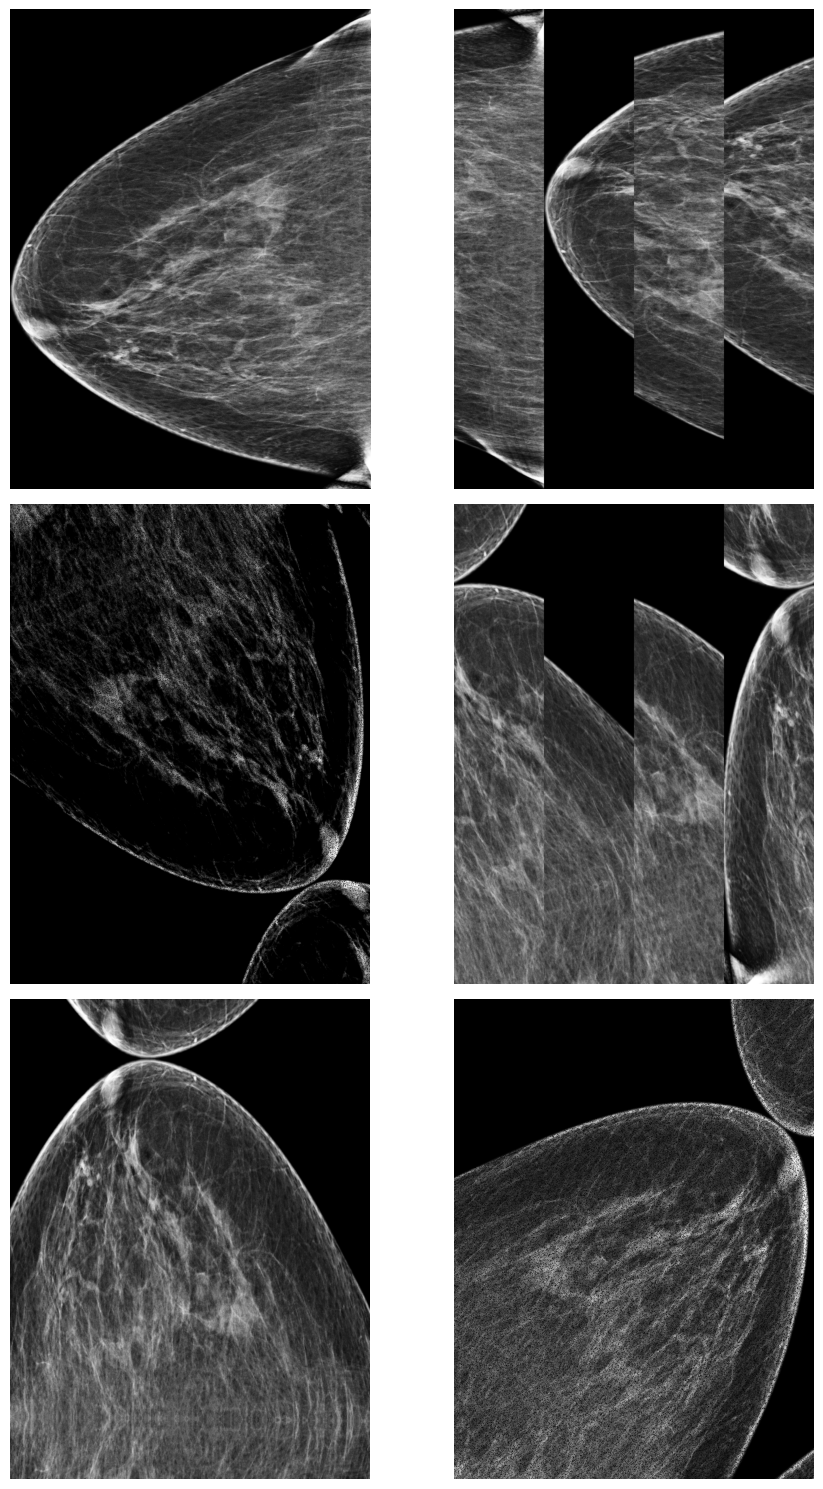

In [16]:
def show_augmentation(transform: A,
                      image: str) -> None:
    rows = 3
    cols = 2
    
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)
    img_transformed = transform(image=img_orig)['image']

    fig = plt.figure(figsize=(10,15))
    fig.add_subplot(rows, cols, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.axis(False)
    
    for i in range(2, cols* rows +1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(transform(image=img_orig)['image'], cmap='gray')
        plt.axis(False)
    plt.tight_layout()
    
show_augmentation(transform, '../mammo/png_roi/train_images/0/1025/347069540.png')

Now, let's augment and see what we've got. We only augment train split.

In [17]:
def augment_images(image: str,
                   dir_dest: str) -> None:
        
    class_label, id_patient, id_img = re.findall('(\d+)',image)
        
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)

    path_save = os.path.join(dir_dest, class_label, id_patient)
    os.makedirs(path_save, exist_ok=True)
    
    if int(class_label): #if cancer: make 3 augmented copies
        for i in range(3): 
            img_transformed = transform(image=img_orig)['image']
            cv2.imwrite(f'{path_save}/{id_img}_augmented_{i}.png', img_transformed)
    else:
        img_transformed = transform(image=img_orig)['image']
        cv2.imwrite(f'{path_save}/{id_img}_augmented_1.png', img_transformed)
            

In [18]:
train_images = glob.glob(path_train_png + '/*/*/*.png')
for image in tqdm(train_images):
    augment_images(image, path_train_png)

100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 35.35it/s]


In [19]:
def images_to_heap(dir_source: str,
                   dir_save: str) -> None:
    
    images = glob.glob(dir_source + '/*/*/*.png')
    class_labels = set()
    for image in tqdm(images):
        
        class_label, id_patient= re.findall('(\d+)', image)[:2]
        class_labels.add(class_label)
        
        img_name = os.path.basename(image)
        file_name_new = f'{id_patient}_{img_name}'
        shutil.move(image, os.path.join(dir_save, class_label, file_name_new))
        
    #Remove empty folders
    for label in class_labels:        
        path_clean_up = f'{dir_source}/{label}'
        for folder in os.listdir(path_clean_up): 
            try:
                os.removedirs(os.path.join(path_clean_up, folder))
            except:
                pass

In [20]:
images_to_heap(path_train_png, path_train_png)

100%|██████████████████████████████████████| 148/148 [00:00<00:00, 35413.14it/s]


In [21]:
images_to_heap(path_test_png, path_test_png)

100%|████████████████████████████████████████| 16/16 [00:00<00:00, 32864.28it/s]
